In [1]:
import tensorflow as tf
from IPython.display import Image
from tensorflow.python.framework import ops
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import math_ops
import time
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data

mnist = tf.keras.datasets.mnist
(batch_xs, batch_ys), (test_xs, test_ys) = mnist.load_data()


number_of_testsets=len(np.argwhere(test_ys==7))+len(np.argwhere(test_ys==1))
test=np.zeros((number_of_testsets,784))
test_label=np.zeros((number_of_testsets,1))
count=0
for i in range(10000):
    if test_ys[i]==7:
        test[count]+=(test_xs[i]/np.linalg.norm(test_xs[i])).reshape(784)
        test_label[count]+=np.array([1.0])
        count+=1
        if count==number_of_testsets:
            break
    elif test_ys[i]==1:
        test[count]+=(test_xs[i]/np.linalg.norm(test_xs[i])).reshape(784)
        test_label[count]+=np.array([0.0])
        count+=1
        if count==number_of_testsets:
            break
            
            
            
number_of_datasets=len(np.argwhere(batch_ys==7))+len(np.argwhere(batch_ys==1))
data=np.zeros((number_of_datasets, 784))
data_label=np.zeros((number_of_datasets,1))
count=0
for i in range(60000):
    if batch_ys[i]==7:
        data[count]+=(batch_xs[i]/np.linalg.norm(batch_xs[i])).reshape(784)
        data_label[count]+=np.array([1.0])
        count+=1
        if count==number_of_datasets:
            break
    elif batch_ys[i]==1:
        data[count]+=(batch_xs[i]/np.linalg.norm(batch_xs[i])).reshape(784)
        data_label[count]+=np.array([0.0])
        count+=1
        if count==number_of_datasets:
            break

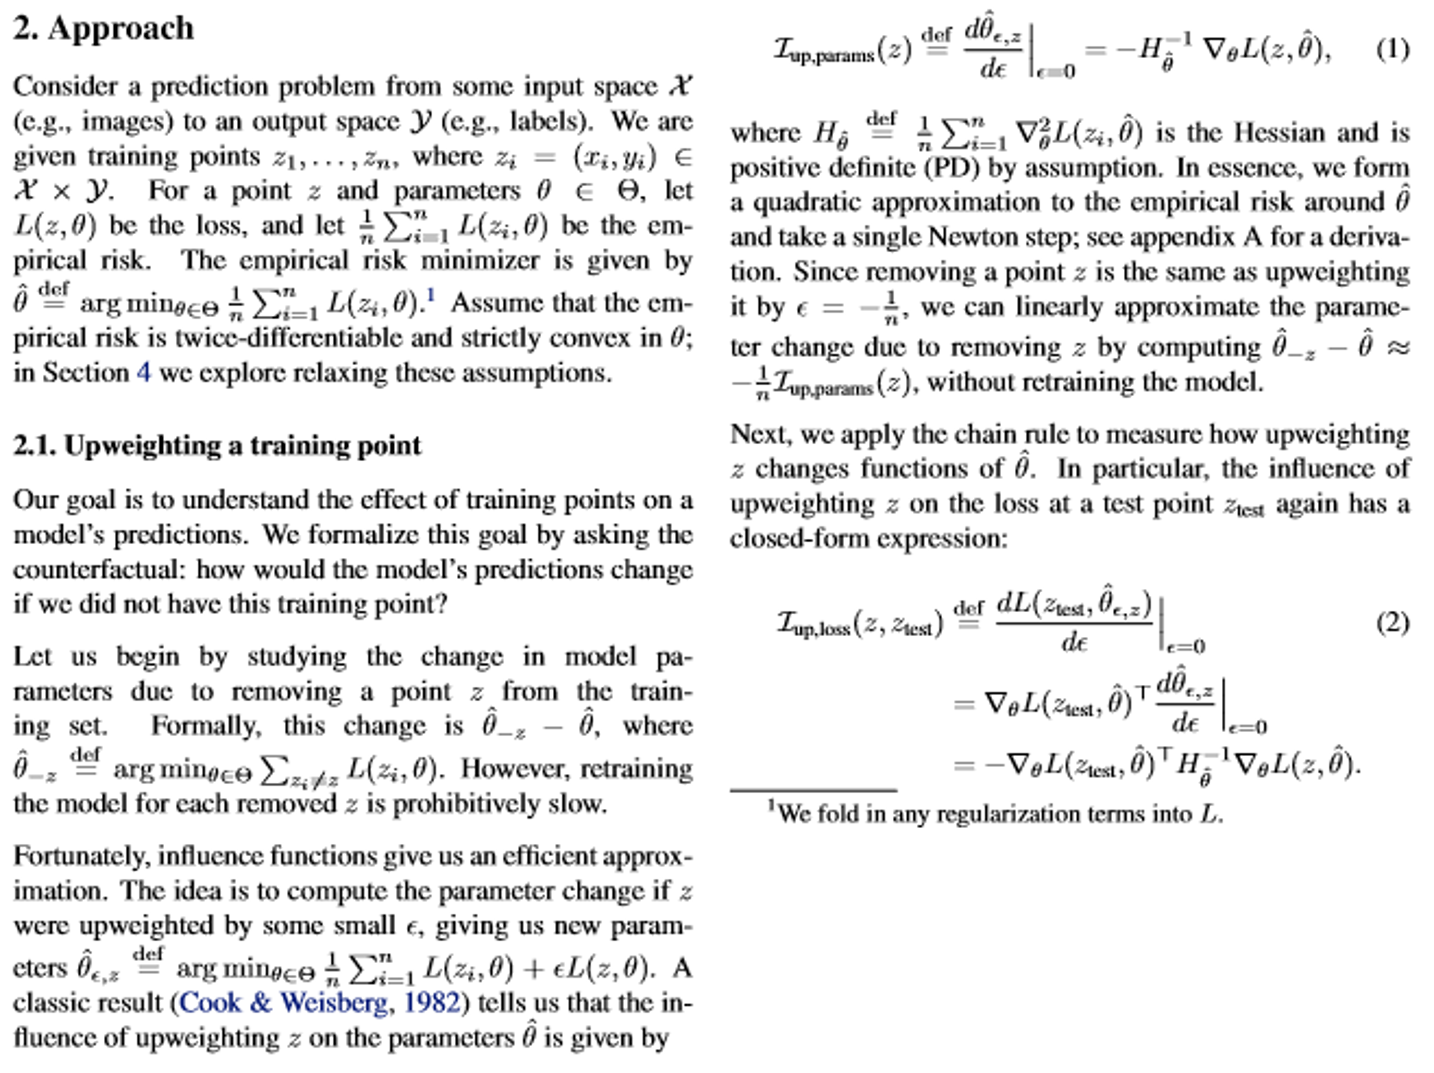

In [2]:
Image(filename='D:/bigdata/Python/pictures/Influence_function_1.png')

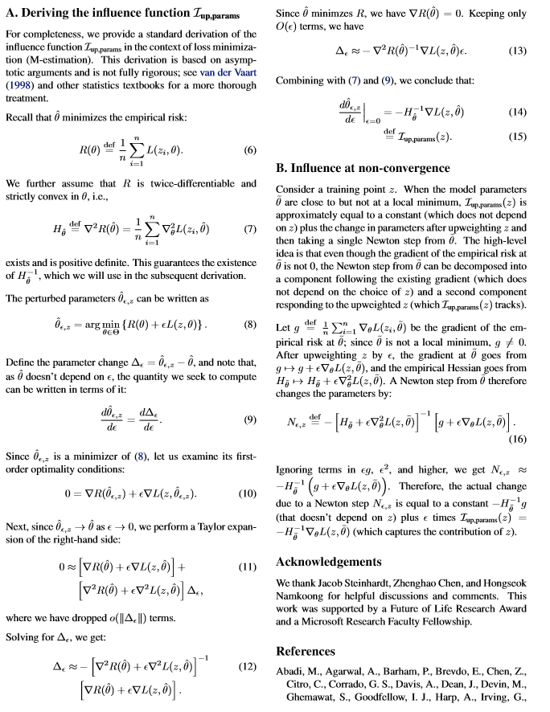

In [3]:
Image(filename='D:/bigdata/Python/pictures/Influence_function_2.png')

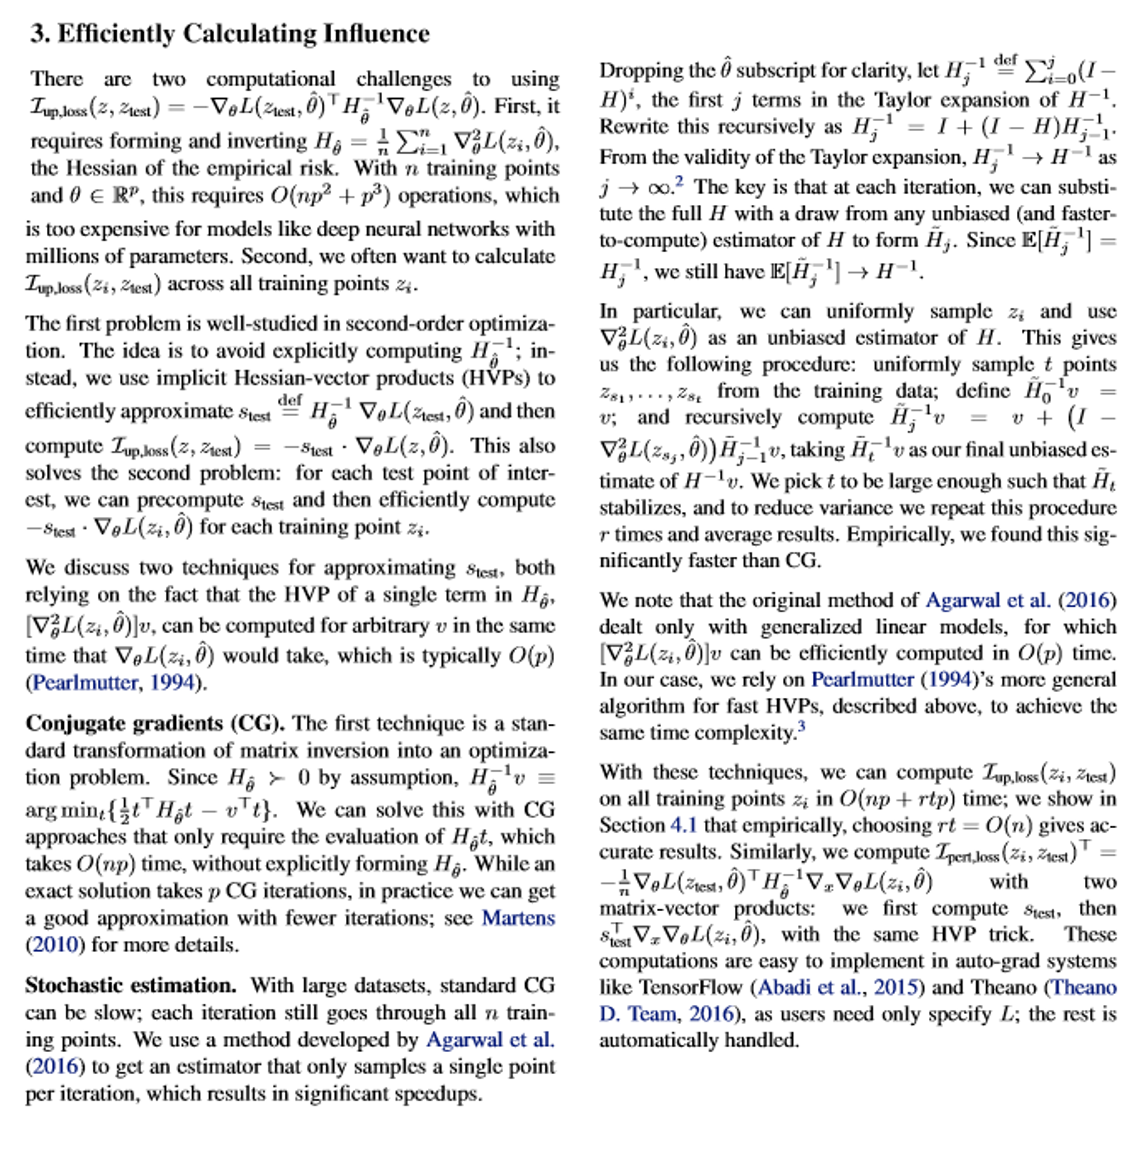

In [4]:
Image(filename='D:/bigdata/Python/pictures/Influence_function_3.png')

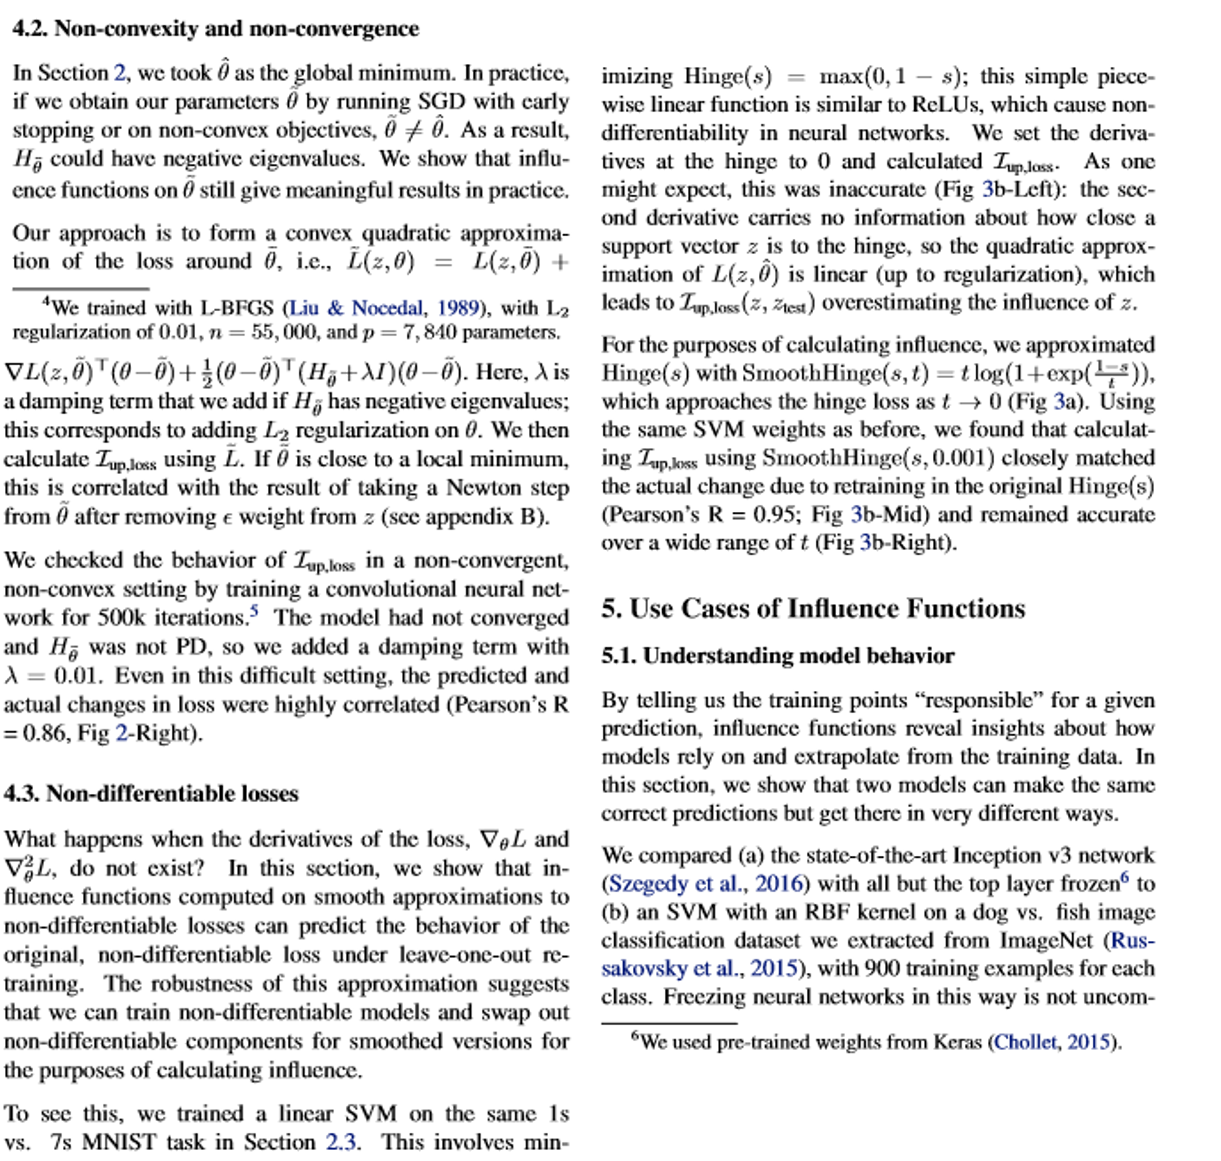

In [5]:
Image(filename='D:/bigdata/Python/pictures/Influence_function_4.png')

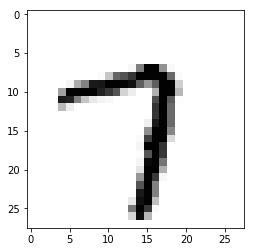

In [6]:
test_index=157
plt.imshow(test[test_index].reshape(28,28),cmap='Greys',interpolation='nearest')

In [7]:
def smooth_hinge_loss(logits, labels, t=1e-3, dty=tf.float64):
    margin=tf.multiply(tf.cast(labels, dtype=dty), logits) 
    exponents = (1-margin)/t
    max_elems = tf.maximum(exponents, tf.zeros_like(exponents))
    log_loss= t * (max_elems + tf.log(tf.exp(exponents - max_elems) 
                                      + tf.exp(tf.zeros_like(exponents) - max_elems)))
    return tf.reduce_mean(log_loss) 




def hinge_loss(logits, labels, dty=tf.float64):
    margin=tf.multiply(tf.cast(labels, dtype=dty), logits) 
    log_loss= tf.maximum(tf.constant(0,dtype=dty), 1-margin)
    return tf.reduce_mean(log_loss) 


def get_accuracy_op(logits, labels, sigmoid=True, dty=tf.float64):
    if sigmoid:
        correct_prediction = tf.equal(tf.cast(L>0.5, tf.int32), tf.cast(labels, tf.int32))
        accuracy = tf.reduce_sum(tf.cast(correct_prediction, tf.int32))
        return accuracy/ tf.shape(labels)[0]
    else:
        preds = tf.sign(logits)
        correct = tf.reduce_sum(tf.cast(tf.equal(preds, tf.cast(labels, dty)),tf.int32))
        return correct / tf.shape(labels)[0]

def hessian_vector_product(ys, xs, v, do_not_sum_up=True):
    # Validate the input
    length = len(xs)
    if len(v) != length:
        raise ValueError("xs and v must have the same length.")
    # First backprop
    grads = tf.gradients(ys, xs)
    
    # grads = xs
    assert len(grads) == length
    elemwise_products = [
      math_ops.multiply(grad_elem, array_ops.stop_gradient(v_elem))
      for grad_elem, v_elem in zip(grads, v) if grad_elem is not None
    ]
    # Second backprop  
    if do_not_sum_up:
        seperate=[]
        for i in range(length):
            seperate.append(tf.gradients(elemwise_products[i], xs[i])[0])
        grads_with_none = seperate
    else:
        grads_with_none = tf.gradients(elemwise_products, xs)
        
    return_grads = [grad_elem if grad_elem is not None \
      else tf.zeros_like(x) \
      for x, grad_elem in zip(xs, grads_with_none)]
    return return_grads

In [8]:
tf.reset_default_graph()
nb_clases=1
dty=tf.float64
scale=1e0
damping=1e-2

I=tf.eye(784, dtype=dty)
we={}
we[0]=784*1
w1=tf.get_variable('w1', [we[0]], initializer=tf.initializers.truncated_normal, dtype=dty)
w1=w1/tf.norm(w1)
w1=w1/tf.constant(1e6, dtype=dty)
params=[w1]


Hess=tf.placeholder(dty, shape=[w1.get_shape()[0], w1.get_shape()[0]],name='inverse') 
cur_in=tf.placeholder(dty, shape=[w1.get_shape()[0], w1.get_shape()[0]],name='inverse') 
v_cur_est=[tf.placeholder(dty, shape=a.get_shape(), name="v_cur_est"+str(i)) for i, a in enumerate(params)]
hessian_vector_val_place=[tf.placeholder(dty, shape=a.get_shape()[0], name="hessian_vector_val_place"+str(i)) for i, a in enumerate(params)]
Test = [tf.placeholder(dty, shape=a.get_shape(), name="v_cur_est"+str(i)) for i, a in enumerate(params)]

####################### LOSS ######################
X=tf.placeholder(dty, [None, 784],name="X")
Y=tf.placeholder(dty,[None, nb_clases],name="Y")
L=tf.matmul(X,tf.reshape(w1,[-1,1]))
L=tf.nn.sigmoid(L)


Z=tf.placeholder(dty, [None, 784],name="Z")
Y_of_Z_train=tf.placeholder(dty, [None, nb_clases],name="Y_of_Z_train")
L_Z=tf.matmul(Z,tf.reshape(w1,[-1,1]))
L_Z=tf.nn.sigmoid(L_Z)


Z_test=tf.placeholder(dty, [None, 784], name="Z_test")
Y_test=tf.placeholder(dty, [None, nb_clases], name="Y_test")
L_test=tf.matmul(Z_test, tf.reshape(w1,[-1,1]))
L_test=tf.nn.sigmoid(L_test)
###################################################
####################### Loss ######################

cost=tf.reduce_mean(-tf.reduce_sum(Y * tf.log(L+1e-6)+(1-Y)* tf.log(1-L+1e-6),1)) # gradient vanishing 방지
cost+=damping*tf.nn.l2_loss(params)

upweighting_loss=tf.reduce_mean(-tf.reduce_sum(Y_of_Z_train * tf.log(L_Z+1e-6)+(1-Y_of_Z_train)* tf.log(1-L_Z+1e-6),1)) # gradient vanishing 방지
upweighting_loss+=damping*tf.nn.l2_loss(params)

Test_loss=tf.reduce_mean(-tf.reduce_sum(Y_test * tf.log(L_test+1e-6)+(1-Y_test)* tf.log(1-L_test+1e-6),1)) # gradient vanishing 방지
Test_loss+=damping*tf.nn.l2_loss(params)

####################### grads ######################
test_grad=tf.gradients(Test_loss, params)
train_grad=tf.gradients(upweighting_loss, params)
####################### Hessians ######################
true_hess=tf.hessians(cost,params)
####################### H dot v ########################
hessian_vector_val=hessian_vector_product(cost, params, v_cur_est, True)
########################  H inverse ######################## 
estimation_IHVP=[g+cur_e-HV/scale 
                 for g, HV, cur_e in zip(Test, hessian_vector_val, v_cur_est)] 

estimation_inverse=I+cur_in-tf.matmul(Hess, cur_in)/scale 
################################################



train_op = tf.train.AdamOptimizer(1e-2).minimize(cost)
accuracy=get_accuracy_op(L, Y)
sess=tf.Session()
sess.run(tf.global_variables_initializer())

for epoch in range(1501):
    for i in range(26):
        batch_xs, batch_ys = data[i*500:(i+1)*500], data_label[i*500:(i+1)*500]
        _=sess.run([train_op], feed_dict={X:batch_xs, Y:batch_ys})  
    if epoch%500==0 and epoch>0:
        c = sess.run(accuracy, feed_dict={X:test, Y:test_label})
        a = sess.run(accuracy, feed_dict={X:data, Y:data_label})
        ccc = sess.run(cost, feed_dict={X:test, Y:test_label})
        print('Train accuracy: ',a, ' Test accuracy: ',c, ' cost: ',ccc)

       


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train accuracy:  0.953947874221573  Test accuracy:  0.9528432732316228  cost:  0.6931450107744137
Train accuracy:  0.9537941108633813  Test accuracy:  0.9523809523809523  cost:  0.6931450102831586
Train accuracy:  0.9537941108633813  Test accuracy:  0.9523809523809523  cost:  0.6931450102818074


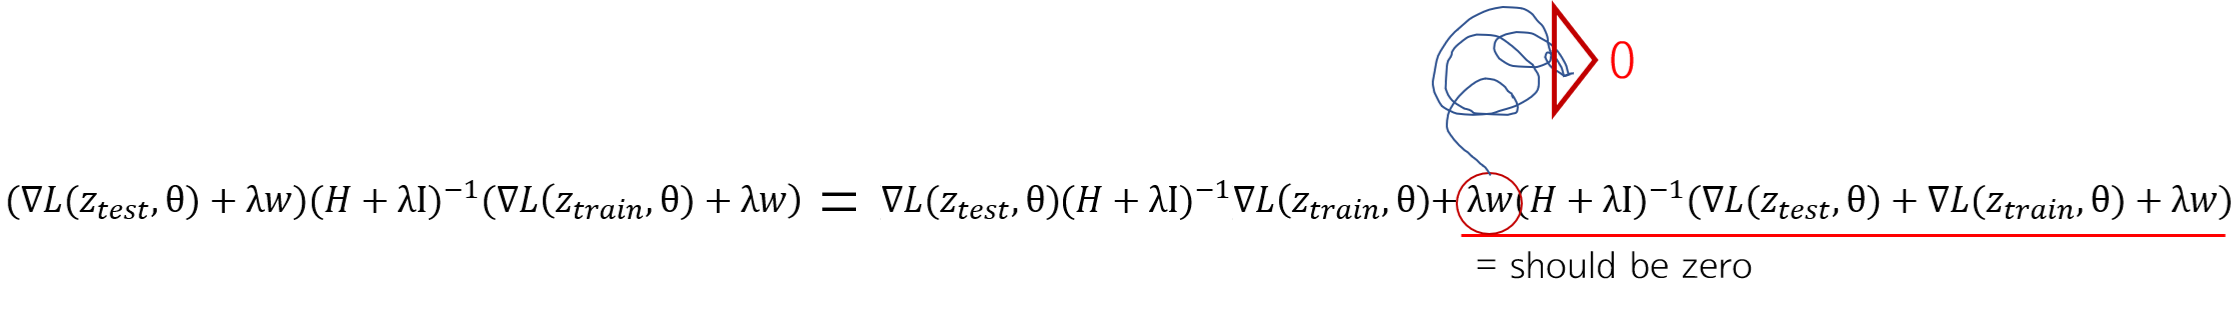

In [26]:
Image(filename='D:/bigdata/Python/pictures/Influence_function_formula_lambda.png')

In [10]:
sess.run(tf.nn.l2_loss(params)).sum()

5.000000000000001e-13

# Hessian Inverse computing

## Numpy direct inverse

In [11]:
true_h=sess.run(true_hess[0], feed_dict={X:data, Y:data_label})
inv=np.linalg.inv(true_h)

In [12]:
np.linalg.norm(true_h)

0.312246772578134

## Lissa Algorithms

In [13]:
cur_estimate=sess.run(I)
start_time = time.time()
for j in range(5001):
    cur_estimate=sess.run(estimation_inverse, feed_dict={Hess:true_h, cur_in:cur_estimate})
inverse= cur_estimate/scale
duration = time.time() - start_time
print('Inverse Hessian by Lissa: took %s minute %s sec' % (duration//60, duration%60))


Inverse Hessian by Lissa: took 1.0 minute 26.35564684867859 sec


### Error

In [14]:
print('Lissa Identity Error: ',abs(np.dot(true_h,inverse)-np.eye(784)).sum())
print('Numpy Identity Error: ',abs(np.dot(true_h,inv)-np.eye(784)).sum())
print('Inverse Error: ',abs(inverse-inv).sum())

Lissa Identity Error:  7.377123443899149e-12
Numpy Identity Error:  8.885253150530524e-13
Inverse Error:  8.14190490313387e-10


# IHVP 

In [15]:
test_val=sess.run(test_grad, feed_dict={Z_test:test[test_index].reshape((1,784)), Y_test:test_label[test_index].reshape((1,1))})
IHVP=np.dot(test_val[0], inv)

In [16]:
start_time = time.time()
cur_estimate=test_val.copy()
feed1={place:cur for place, cur in zip(Test, test_val)}
for j in range(5001):
    feed2={place:cur for place, cur in zip(v_cur_est, cur_estimate)}
    r=np.random.randint(len(data), size=[1024])
    cur_estimate=sess.run(estimation_IHVP, feed_dict={X:data[r], Y:data_label[r], **feed1,**feed2})
    if j%2500==0 and j>0:
        print(cur_estimate[0][0])
inverse_hvp = [b/scale for b in cur_estimate]
duration = time.time() - start_time
print('Inverse HVP by HVPs+Lissa: took %s minute %s sec' % (duration//60, duration%60))

8.957474568301668e-13
8.957474568409125e-13
Inverse HVP by HVPs+Lissa: took 0.0 minute 43.141655921936035 sec


In [17]:
abs(IHVP-inverse_hvp[0]).sum()

1.6311743678053348

In [18]:
s=time.time()
val_lissa=[]
for i in range(number_of_datasets):
    if data_label[i][0]==test_label[test_index][0]:
        train_grad_loss_val=sess.run(train_grad, feed_dict={Z:data[i].reshape((1,784)), Y_of_Z_train:data_label[i].reshape((1,1))})
        val_lissa.append([i,np.dot(np.concatenate(inverse_hvp), np.concatenate(train_grad_loss_val))])
duration = time.time() - s
print('Multiplying by %s train examples took %s minute %s sec' % (1, duration//60, duration%60))
val_lissa=sorted(val_lissa, key=lambda x: x[1])

Multiplying by 1 train examples took 0.0 minute 9.074735879898071 sec


In [19]:
s=time.time()
val=[]
for i in range(number_of_datasets):
    if data_label[i][0]==test_label[test_index][0]:
        train_grad_loss_val=sess.run(train_grad, feed_dict={Z:data[i].reshape((1,784)), Y_of_Z_train:data_label[i].reshape((1,1))})
        val.append([i,np.dot(IHVP, np.concatenate(train_grad_loss_val))])
duration = time.time() - s
print('Multiplying by %s train examples took %s minute %s sec' % (1, duration//60, duration%60))
val=sorted(val, key=lambda x: x[1])

Multiplying by 1 train examples took 0.0 minute 8.802465915679932 sec


#  Pictures

In [20]:
print(val[0][0], val[1][0], val[2][0], val[3][0], val[4][0], val[5][0])
print(val[-1][0], val[-2][0], val[-3][0], val[-4][0], val[-5][0], val[-6][0])

9309 6463 11720 10878 10648 7869
3441 932 2799 3200 1147 9394


In [21]:
print(val_lissa[0][0], val_lissa[1][0], val_lissa[2][0], val_lissa[3][0], val_lissa[4][0], val_lissa[5][0])
print(val_lissa[-1][0], val_lissa[-2][0], val_lissa[-3][0], val_lissa[-4][0], val_lissa[-5][0], val_lissa[-6][0])

9309 6463 11720 10878 10648 7869
3441 932 2799 3200 1147 9394


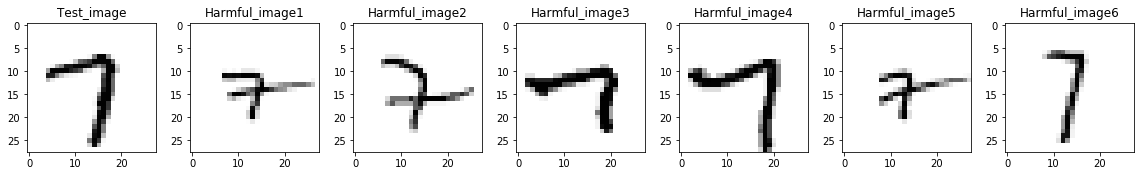

In [22]:
fig = plt.figure(figsize=(16, 4))
for i in range(1, 8):
    ax = plt.subplot(1, 7, i)
    if i == 1:
        plt.imshow(test[test_index].reshape(28,28),cmap='Greys',interpolation='nearest')
        ax.set_title('Test_image')
    elif i == 2:
        plt.imshow(data[val[0][0]].reshape(28,28),cmap='Greys',interpolation='nearest')
        ax.set_title('Harmful_image1')
    elif i == 3:
        plt.imshow(data[val[1][0]].reshape(28,28),cmap='Greys',interpolation='nearest')
        ax.set_title('Harmful_image2')
    elif i == 4:
        plt.imshow(data[val[2][0]].reshape(28,28),cmap='Greys',interpolation='nearest')
        ax.set_title('Harmful_image3')
    elif i == 5:
        plt.imshow(data[val[3][0]].reshape(28,28),cmap='Greys',interpolation='nearest')
        ax.set_title('Harmful_image4')
    elif i == 6:
        plt.imshow(data[val[4][0]].reshape(28,28),cmap='Greys',interpolation='nearest')
        ax.set_title('Harmful_image5')
    elif i == 7:
        plt.imshow(data[val[5][0]].reshape(28,28),cmap='Greys',interpolation='nearest')
        ax.set_title('Harmful_image6')
plt.tight_layout()
plt.show()

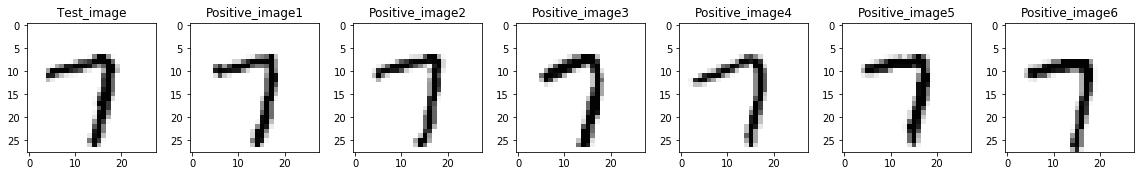

In [23]:
fig = plt.figure(figsize=(16, 4))
for i in range(1, 8):
    ax = plt.subplot(1, 7, i)
    if i == 1:
        plt.imshow(test[test_index].reshape(28,28),cmap='Greys',interpolation='nearest')
        ax.set_title('Test_image')
    elif i == 2:
        plt.imshow(data[val[-1][0]].reshape(28,28),cmap='Greys',interpolation='nearest')
        ax.set_title('Positive_image1')
    elif i == 3:
        plt.imshow(data[val[-2][0]].reshape(28,28),cmap='Greys',interpolation='nearest')
        ax.set_title('Positive_image2')
    elif i == 4:
        plt.imshow(data[val[-3][0]].reshape(28,28),cmap='Greys',interpolation='nearest')
        ax.set_title('Positive_image3')
    elif i == 5:
        plt.imshow(data[val[-4][0]].reshape(28,28),cmap='Greys',interpolation='nearest')
        ax.set_title('Positive_image4')
    elif i == 6:
        plt.imshow(data[val[-5][0]].reshape(28,28),cmap='Greys',interpolation='nearest')
        ax.set_title('Positive_image5')
    elif i == 7:
        plt.imshow(data[val[-6][0]].reshape(28,28),cmap='Greys',interpolation='nearest')
        ax.set_title('Positive_image6')
plt.tight_layout()
plt.show()

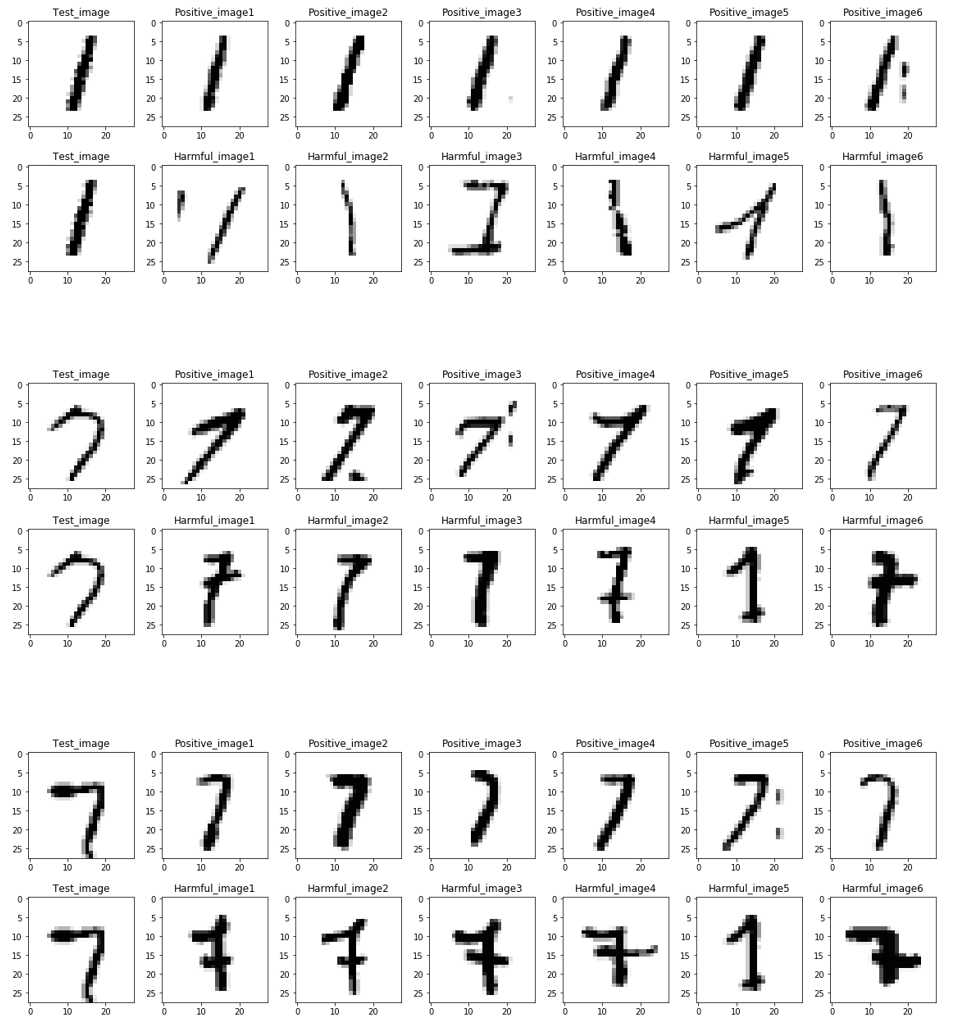

In [24]:
Image(filename='D:/bigdata/Python/pictures/test 1.png')

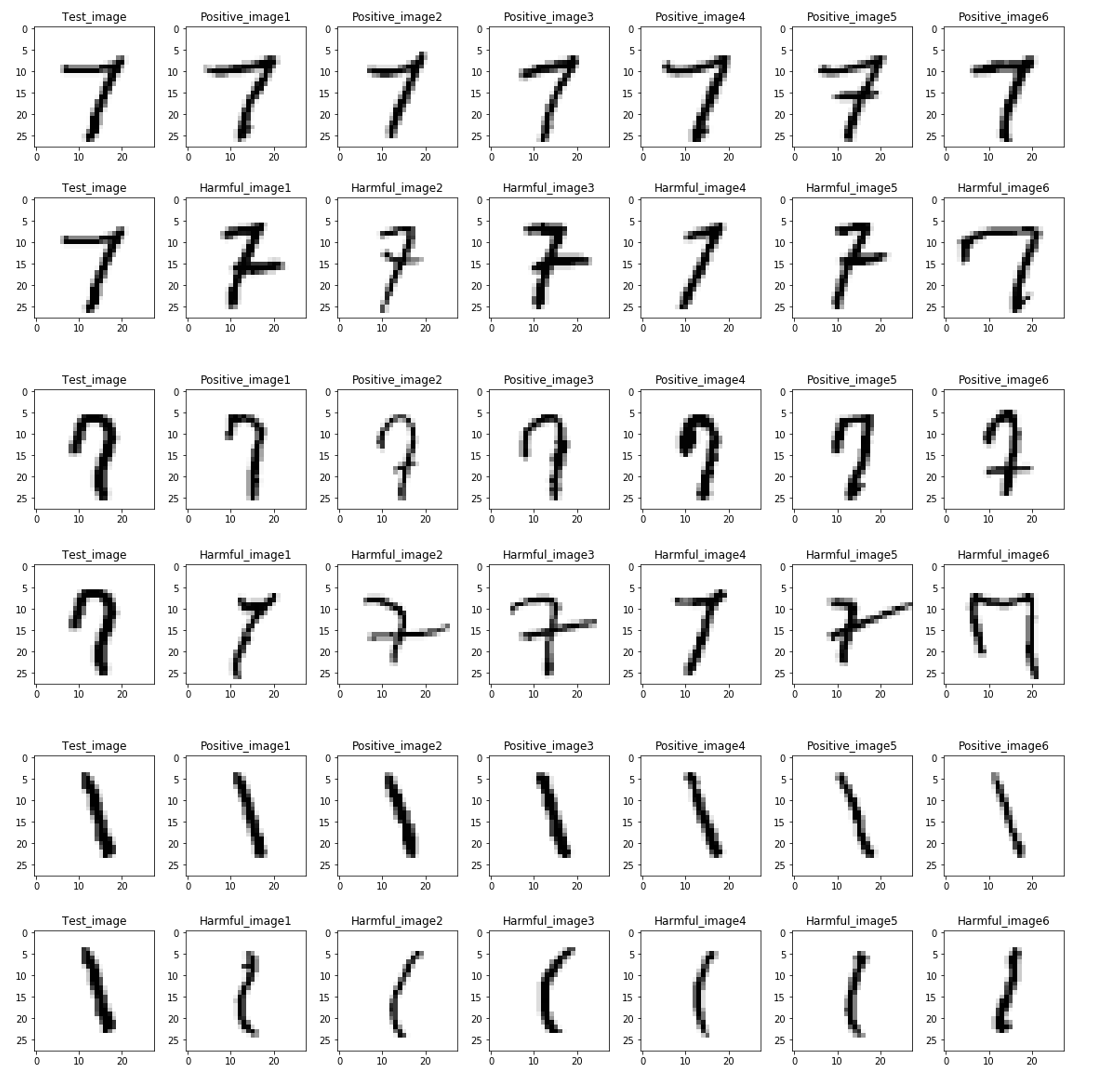

In [25]:
Image(filename='D:/bigdata/Python/pictures/test 2.png')